In [21]:
!pip install decord

In [22]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import ImageGrid

#warnings.simplefilter(action="ignore")
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import ops
from keras import layers
import tensorflow as tf
keras.backend.backend(), keras.__version__

('tensorflow', '3.4.1')

In [23]:
physical_devices = tf.config.list_physical_devices("GPU")
keras.mixed_precision.set_global_policy("mixed_float16")
strategy = tf.distribute.MirroredStrategy()

HOME = os.getcwd()
tf.__version__, HOME, strategy

('2.15.0',
 '/kaggle/working/VideoSwin',
 <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy at 0x7cb07220b4c0>)

In [24]:
def show_sequence(seq, sample=8, title=""):
    """Plot a sequence of images horizontally"""
    # clip is [T, H, W, 3]
    assert seq.shape[-1] == 3
    fig = plt.figure(figsize=(20, 2.5))
    fig.suptitle(title, fontsize=16)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, sample), axes_pad=0.1)
    for ax, img in zip(grid, seq):
        ax.imshow(img.astype("uint8"))
        ax.set_axis_off()
    plt.show()
    return

In [25]:
dataset = "/kaggle/input/ucf101/UCF-101"
class_folders = os.listdir(dataset)
label2id = {label: i for i, label in enumerate(class_folders)}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'HorseRace',
 1: 'StillRings',
 2: 'ApplyLipstick',
 3: 'HammerThrow',
 4: 'VolleyballSpiking',
 5: 'Biking',
 6: 'PlayingCello',
 7: 'BodyWeightSquats',
 8: 'TaiChi',
 9: 'Punch',
 10: 'BreastStroke',
 11: 'Billiards',
 12: 'BoxingPunchingBag',
 13: 'BasketballDunk',
 14: 'PoleVault',
 15: 'ThrowDiscus',
 16: 'BaseballPitch',
 17: 'Knitting',
 18: 'SumoWrestling',
 19: 'HorseRiding',
 20: 'Mixing',
 21: 'BrushingTeeth',
 22: 'HighJump',
 23: 'Skijet',
 24: 'SkateBoarding',
 25: 'MilitaryParade',
 26: 'IceDancing',
 27: 'CricketShot',
 28: 'Fencing',
 29: 'JugglingBalls',
 30: 'Swing',
 31: 'RockClimbingIndoor',
 32: 'PlayingFlute',
 33: 'SalsaSpin',
 34: 'CricketBowling',
 35: 'Typing',
 36: 'ApplyEyeMakeup',
 37: 'PlayingTabla',
 38: 'BalanceBeam',
 39: 'FloorGymnastics',
 40: 'HeadMassage',
 41: 'FrisbeeCatch',
 42: 'Rowing',
 43: 'Hammering',
 44: 'CuttingInKitchen',
 45: 'BenchPress',
 46: 'PushUps',
 47: 'Nunchucks',
 48: 'Archery',
 49: 'LongJump',
 50: 'BlowingCandles',
 51

In [26]:
def create_dataframe(path):
    data = []
    for class_name in os.listdir(path):
        class_dir = os.path.join(path, class_name)
        if os.path.isdir(class_dir) and class_name in label2id:
            for video_file in os.listdir(class_dir):
                video_path = os.path.join(class_dir, video_file)
                data.append(
                    {
                        "video_path": os.path.abspath(video_path),
                        "label": label2id[class_name],
                        "class_name": class_name,
                    }
                )
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df


dataset_df = create_dataframe(dataset)
train_df, test_df = train_test_split(dataset_df, test_size=0.2)
train_df.shape, test_df.shape

((10656, 3), (2664, 3))

In [27]:
test_df.head()

,video_path,label,class_name
5682,/kaggle/input/ucf101/UCF-101/Punch/v_Punch_g19...,9,Punch
7698,/kaggle/input/ucf101/UCF-101/PlayingPiano/v_Pl...,54,PlayingPiano
1795,/kaggle/input/ucf101/UCF-101/CleanAndJerk/v_Cl...,88,CleanAndJerk
676,/kaggle/input/ucf101/UCF-101/ApplyEyeMakeup/v_...,36,ApplyEyeMakeup
4332,/kaggle/input/ucf101/UCF-101/Punch/v_Punch_g10...,9,Punch


In [28]:
input_size = 224
num_frame = 32
sampling_rate = 2
batch_size = 4 * strategy.num_replicas_in_sync

In [29]:
def read_video(file_path):
    vr = VideoReader(file_path.numpy().decode("utf-8"))
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.uint8)
    frame = tf.image.resize(frame, size=list(output_size))
    return frame

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([None, None, None, 3])
    return video, tf.cast(label, dtype=tf.float32)

In [30]:
def uniform_temporal_subsample(
    x, num_samples, clip_idx, total_clips, frame_rate=1, temporal_dim=-4
):
    t = tf.shape(x)[temporal_dim]
    max_offset = t - num_samples * frame_rate
    step = max_offset // total_clips
    offset = clip_idx * step
    indices = tf.linspace(
        tf.cast(offset, tf.float32),
        tf.cast(offset + (num_samples - 1) * frame_rate, tf.float32),
        num_samples,
    )
    indices = tf.clip_by_value(indices, 0, tf.cast(t - 1, tf.float32))
    indices = tf.cast(tf.round(indices), tf.int32)
    return tf.gather(x, indices, axis=temporal_dim)


def clip_generator(image, num_frames=32, frame_rate=1, num_clips=1, crop_size=224):
    clips_list = []
    for i in range(num_clips):
        frame = uniform_temporal_subsample(
            image, num_frames, i, num_clips, frame_rate=frame_rate, temporal_dim=0
        )
        clips_list.append(frame)
    video = tf.stack(clips_list)
    video = tf.reshape(video, [num_clips * num_frames, crop_size, crop_size, 3])
    return video

In [31]:
def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df["video_path"].values, df["label"].values)
    )
    ds = ds.repeat() if shuffle else ds
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(
        lambda x, y: (clip_generator(x, num_frame, sampling_rate, num_clips=1), y),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [32]:
train_ds = create_dataloader(train_df, batch_size, shuffle=True)
test_ds = create_dataloader(test_df, batch_size, shuffle=False)

In [33]:
temp_ds = create_dataloader(test_df, 5, shuffle=False)
x, y = next(iter(temp_ds))
x.shape, y

(TensorShape([5, 32, 224, 224, 3]),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([ 9., 54., 88., 36.,  9.], dtype=float32)>)

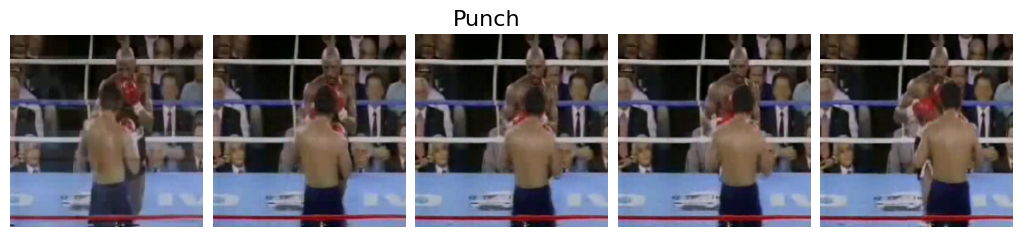

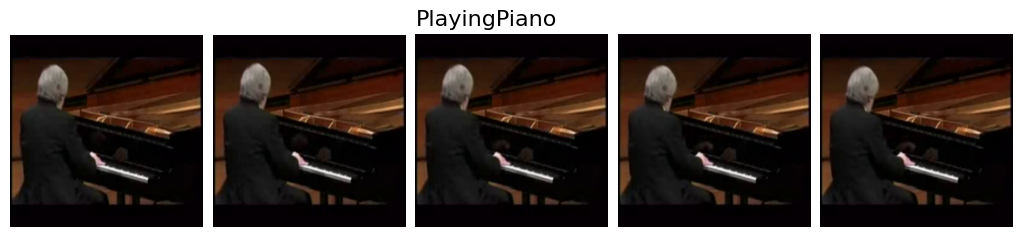

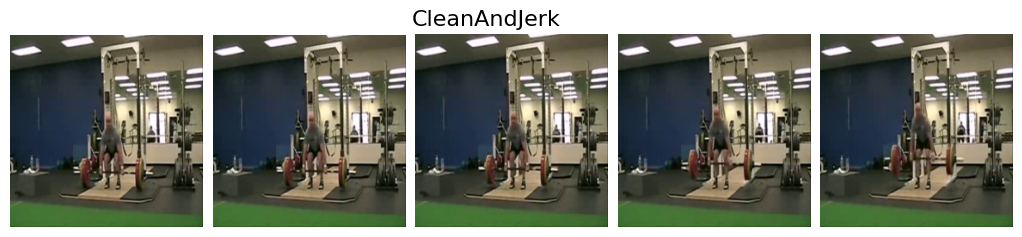

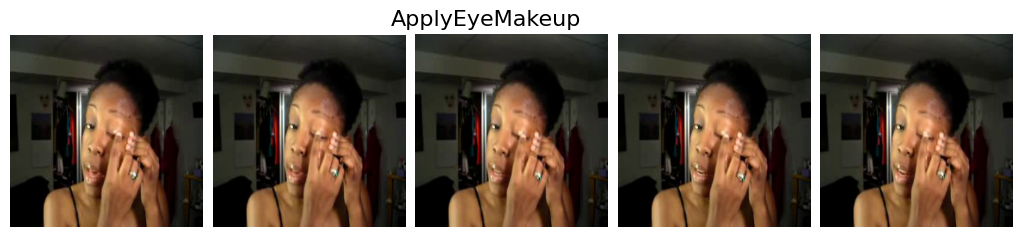

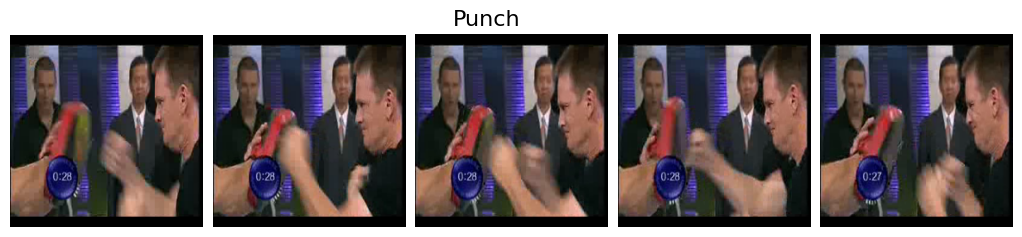

In [34]:
for i in range(len(x)):
    show_sequence(x.numpy()[i], sample=5, title=id2label[y[i].numpy()])

In [35]:
%cd {HOME}
!git clone https://github.com/innat/VideoSwin.git
%cd VideoSwin
!pip install -q -e . 

/kaggle/working/VideoSwin


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'VideoSwin'...
remote: Enumerating objects: 840, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 840 (delta 208), reused 221 (delta 146), pack-reused 534
Receiving objects: 100% (840/840), 7.86 MiB | 34.41 MiB/s, done.
Resolving deltas: 100% (490/490), done.
/kaggle/working/VideoSwin/VideoSwin


In [36]:
from videoswin.backbone import VideoSwinBackbone
from videoswin.model import VideoSwinT

In [37]:
!wget https://github.com/innat/VideoSwin/releases/download/v2.0/videoswin_tiny_kinetics400.weights.h5 -q
!ls


CITATION.cff  data		     test
LICENSE       guides		     videoswin
MODEL_ZOO.md  requirements.cuda.txt  videoswin.egg-info
README.md     requirements.txt	     videoswin_tiny_kinetics400.weights.h5
assets	      setup.py


In [38]:
with strategy.scope():
    backbone = VideoSwinT(
        include_top=False,
        include_rescaling=True, 
        input_shape=(32, 224, 224, 3), 
        #window_size=(8, 7, 7),
    )
    backbone.load_weights(
        'videoswin_tiny_kinetics400.weights.h5'
    )
    backbone.trainable=False
    inputs = backbone.input
    x = backbone(inputs)
    x = keras.layers.GlobalAveragePooling3D(name="avg_pool")(x)
    outputs = layers.Dense(
        len(class_folders), 
        dtype="float32", 
        activation=None
    )(x)
    model = keras.Model(inputs, outputs)

In [39]:



with strategy.scope():
    # compile the model
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(k=1),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3),
            keras.metrics.SparseTopKCategoricalAccuracy(k=5),
        ],
    )

In [40]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch=len(train_df) // batch_size,
    validation_steps=len(test_df) // batch_size,
    epochs=1,
)

1332/1332 ━━━━━━━━━━━━━━━━━━━━ 2568s 2s/step - acc: 0.6363 - loss: 1.9758 - sparse_top_k_categorical_accuracy: 0.6363 - sparse_top_k_categorical_accuracy_1: 0.7549 - sparse_top_k_categorical_accuracy_2: 0.7880 - val_acc: 0.9535 - val_loss: 0.1841 - val_sparse_top_k_categorical_accuracy: 0.9535 - val_sparse_top_k_categorical_accuracy_1: 0.9955 - val_sparse_top_k_categorical_accuracy_2: 0.9985


In [43]:
model.save_weights('model.weights.h5')




In [44]:
!ls


CITATION.cff  guides		     test
LICENSE       model.h5		     videoswin
MODEL_ZOO.md  model.weights.h5	     videoswin.egg-info
README.md     requirements.cuda.txt  videoswin_tiny_kinetics400.weights.h5
assets	      requirements.txt
data	      setup.py


In [59]:
(a,b) = load_video("/kaggle/input/walking/WhatsApp Video 2024-08-02 at 01.53.00_94c48086.mp4", 1)
abc = clip_generator(a, num_frame, sampling_rate, num_clips=1)
abc=np.expand_dims(abc, axis=0)
logits = model(abc)  

probs = tf.nn.softmax(logits, axis=-1)  

top5_probs, top5_indices = tf.math.top_k(probs, k=5)

top5_probs = top5_probs.numpy()
top5_indices = top5_indices.numpy()

top5_labels_confidences = []

for i in range(top5_indices.shape[0]):  
    labels_confidences = [(id2label[idx], prob) for idx, prob in zip(top5_indices[i], top5_probs[i])]
    top5_labels_confidences.append(labels_confidences)

for batch_index, labels_confidences in enumerate(top5_labels_confidences):
    print(f"Batch {batch_index}:")
    for label, confidence in labels_confidences:
        print(f"Label: {label}, Confidence: {confidence}")


Batch 0:
Label: CricketBowling, Confidence: 0.5329557657241821
Label: MoppingFloor, Confidence: 0.10140388458967209
Label: HandstandWalking, Confidence: 0.08885455131530762
Label: WalkingWithDog, Confidence: 0.05558247119188309
Label: BabyCrawling, Confidence: 0.05027228221297264
